In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import lightning
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger
import utils
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error


In [2]:
class LSTMModel(lightning.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, learning_rate):
        super().__init__()
        self.lr = learning_rate
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out[:,-1,:].squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.criterion(out, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.criterion(out, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [3]:
def create_sequences(x, y, seq_length):
    xs = []
    ys = []
    for i in range(len(x) - seq_length - 1):
        _x = x[i : i + seq_length]
        _y = y[i+seq_length]
        xs.append(_x)
        ys.append(_y)
    return np.array(xs), np.array(ys)


In [4]:
df_train, df_test, df_valid = utils.load_cleaned_data()

class ClimateDataset(torch.utils.data.Dataset):
    def __init__(self, df, seq_length) -> None:
        super().__init__()
        self.df = df
        self.x = df.iloc[:, 1:].values
        self.y = df.iloc[:, 0].values
        self.sequences, self.targets = create_sequences(self.x, self.y, seq_length)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        x = self.sequences[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

BATCH_SIZE = 32
SEQ_LENGTH = 2

dataloader_train = torch.utils.data.DataLoader(ClimateDataset(df_train, SEQ_LENGTH), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)
dataloader_valid = torch.utils.data.DataLoader(ClimateDataset(df_valid, SEQ_LENGTH), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)


In [5]:

def predict(model, dataloader):
    preds = []
    true = []
    ds = ClimateDataset(df_test, SEQ_LENGTH)

    it = iter(dataloader)

    while True:
        try:
            x, y = next(it)
            pred = model.forward(x)
            preds.append(pred.detach().numpy())
            true.append(y.detach().numpy())
        except StopIteration:
            break
    return np.array(preds), np.array(true)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


lr: 0.01 hidden_size: 16 num_layer: 3


2023-12-02 17:03:33.490706: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 17:03:33.522836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 5.7 K 
1 | fc        | Linear  | 17    
2 | criterion | MSELoss | 0     
--------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params s

Mean Squared Error: 0.26752958
Root Mean Squared Error: 0.5172326


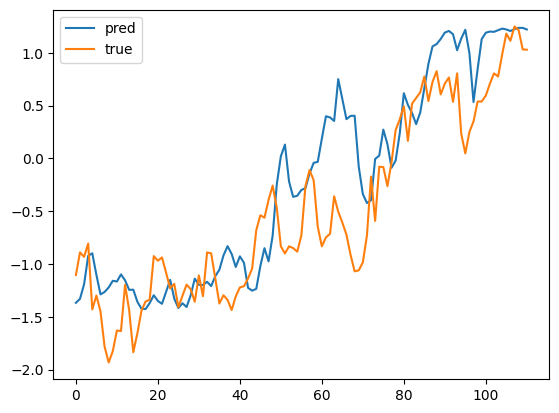

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 10.0 K
1 | fc        | Linear  | 17    
2 | criterion | MSELoss | 0     
--------------------------------------
10.1 K    Trainable params
0         Non-trainable params
10.1 K    Total params
0.040     Total estimated model params size (MB)


lr: 0.01 hidden_size: 16 num_layer: 5


Mean Squared Error: 0.44623074
Root Mean Squared Error: 0.66800505


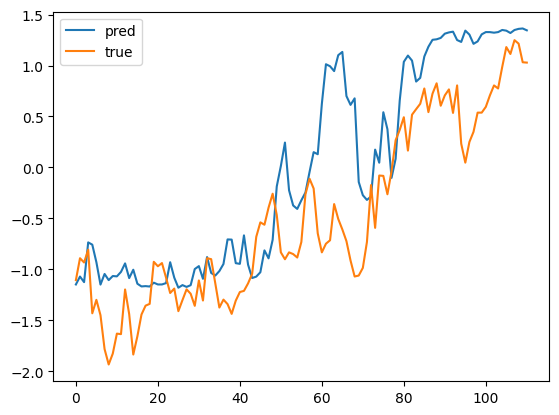

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 16.6 K
1 | fc        | Linear  | 17    
2 | criterion | MSELoss | 0     
--------------------------------------
16.6 K    Trainable params
0         Non-trainable params
16.6 K    Total params
0.066     Total estimated model params size (MB)


lr: 0.01 hidden_size: 16 num_layer: 8


In [6]:
learning_rates = [1e-2, 5e-3, 1e-3]
hidden_sizes = [16, 32, 64]
num_layers = [3, 5, 8]


for lr, hidden_size, num_layer in product(learning_rates, hidden_sizes, num_layers):
    print("lr:", lr, "hidden_size:", hidden_size, "num_layer:", num_layer)
    model = LSTMModel(3, hidden_size=hidden_size, num_layers=num_layer, learning_rate=lr)

    trainer = lightning.Trainer(
    max_epochs=1000, 
    log_every_n_steps=1,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=10),
        ],        
    logger=TensorBoardLogger(f"lstm-logs",name="", version=f"LSTM-lr={lr}, hidden_size={hidden_size}, num_layer={num_layer}")
    )

    
    trainer.fit(model, dataloader_train, dataloader_valid)
    
    dataloader_test = torch.utils.data.DataLoader(ClimateDataset(df_test, SEQ_LENGTH), batch_size=1, shuffle=False, num_workers=15)
    preds, true = predict(model, dataloader_test)

    mse = mean_squared_error(true, preds)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    plt.plot(preds, label="pred")
    plt.plot(true, label="true")
    plt.legend()
    plt.show()
    
